# Analisi i predicció dels accidents de transit a Barcelona 1

In [0]:
# import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek 
from collections import Counter
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.utils import class_weight
from keras import optimizers
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint


In [188]:
from google.colab import files
uploaded = files.upload()

Saving df_clean_tipus_accidents.csv to df_clean_tipus_accidents (2).csv


In [0]:
import io
df_clean = pd.read_csv(io.BytesIO(uploaded['df_clean_tipus_accidents.csv']))
df_clean.drop(['Unnamed: 0'], axis=1, inplace=True)
# df_clean = df_clean[df_clean['Vianant']==1]
    

In [190]:

# df_clean2 = df_clean[df_clean['Vianant']==1]
# Labels are the values we want to predict
Y = pd.get_dummies(df_clean['Descripcio_victimitzacio']) 
# Y = Y.replace({'Ferit lleu': 0}, regex=True)
# Y = Y.replace({'Ferit greu': 1}, regex=True)
# Y = Y.replace({'Mort': 2}, regex=True)


df_clean = pd.concat([df_clean, pd.get_dummies(df_clean['Descripcio_tipus_accident'])], axis=1)

# # Remove the labels from the features
# # axis 1 refers to the columns
X = df_clean.drop(columns = ['Num_Greus', 'Num_Lleus', 'Num_Morts', 'Codi_expedient','Descripcio_victimitzacio',
                                     'Descripcio_tipus_persona','Descripcio_tipus_de_vehicle','Descripcio_tipus_accident'], axis = 1)
# Saving feature names for later use
feature_list = list(X.columns)
num_columns = len(X.columns)
pd.set_option("display.max_columns", num_columns)
X

,NK_Any,Edat,Codi_barri_x,Codi_carrer,Hora_dia,Mes_any,Dia_mes,Longitud,Latitud,Num_Victimes,Num_Vehicles_Implicats,Poblacio,Nombre_vehicles_parc,Any,Sortida_Sol,Posta_Sol,Dif_PostaoSortida_Sol,Num_Semaf_Barri,Codi_barri_y,Dist_semaf,T,HR,PPT,VV10ESC,RVX10,Conductor,Passatger,Vianant,Abast,Abast multiple,Altres,Atropellament,Bolcada (més de dues rodes),Caiguda (dues rodes),Caiguda interior vehicle,Col.lisió frontal,Col.lisió fronto-lateral,Col.lisió lateral,Desconegut,Encalç,Resta sortides de via,Sortida de via amb xoc o col.lisió,Xoc amb animal a la calçada,Xoc contra element estàtic
0,2017,33,64,209900,15,2,7,2.186591,41.415280,1,2,38371,9172,2017.0,7.0,18.0,3.0,2010,64,0.24280,16.3,56,0.0,2.2,4.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,2017,48,64,346402,14,11,7,2.184483,41.415436,1,2,38371,9172,2017.0,7.0,17.0,3.0,2010,64,0.13798,15.9,22,0.0,3.1,6.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,2017,47,64,297001,14,7,27,2.179666,41.415060,1,2,38371,9172,2017.0,6.0,21.0,7.0,2010,64,0.10725,28.5,57,0.0,3.8,7.3,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2017,68,64,297001,20,4,25,2.177034,41.413077,1,1,38371,0,2017.0,6.0,20.0,0.0,2010,64,0.01711,15.1,83,0.0,1.6,3.1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,2017,41,64,297001,11,6,7,2.176086,41.412368,1,2,38371,9172,2017.0,6.0,21.0,5.0,2010,64,0.01015,18.9,67,0.0,2.2,6.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2017,29,64,297001,19,9,30,2.176086,41.412368,1,2,38371,9172,2017.0,7.0,19.0,0.0,2010,64,0.01015,19.8,87,0.0,0.3,2.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,2017,32,64,105304,9,5,11,2.177640,41.410550,1,2,38371,9172,2017.0,6.0,21.0,3.0,2010,64,0.00711,14.0,96,0.0,1.0,2.5,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,2017,26,64,289105,1,11,5,2.179003,41.409722,2,2,38371,2553,2017.0,7.0,17.0,6.0,2010,64,0.00247,15.2,82,0.0,3.2,7.4,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
8,2017,40,64,289105,1,11,5,2.179003,41.409722,2,2,38371,2553,2017.0,7.0,17.0,6.0,2010,64,0.00247,15.2,82,0.0,3.2,7.4,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
9,2017,19,64,350308,13,3,9,2.184175,41.408507,2,1,38371,2553,2017.0,7.0,18.0,5.0,2010,64,0.00287,17.0,58,0.0,2.7,4.9,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


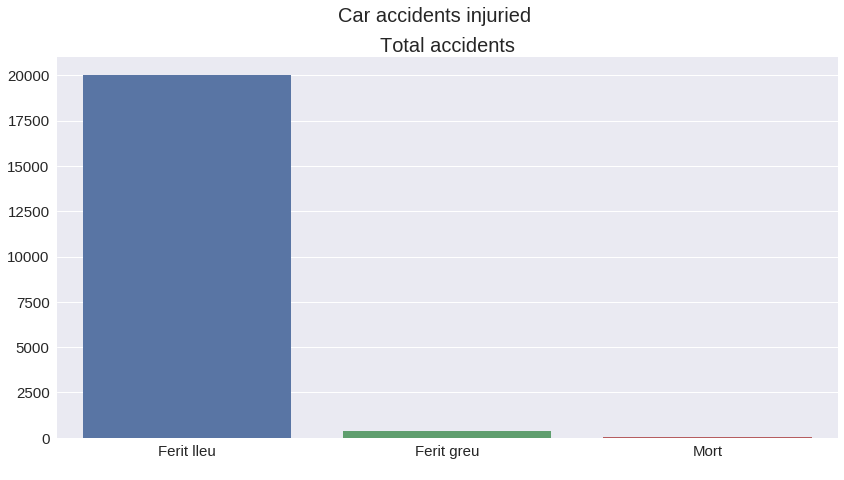

In [191]:
fig, ax2 = plt.subplots(figsize=(14, 7))
sns.countplot(df_clean['Descripcio_victimitzacio'], ax=ax2)
ax2.set_xlabel(' ')
ax2.set_ylabel('')
ax2.set_title('Total accidents', size=20)
ax2.tick_params(labelsize=15)
fig.suptitle('Car accidents injuried', size=20)
plt.show()

In [192]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, 
                                                Y, 
                                                train_size=0.75, 
                                                random_state = 420
                                               )
# Feature Scaling
sc = StandardScaler()  
sc.fit(Xtrain)
Xtrain = sc.transform(Xtrain)  
Xtest = sc.transform(Xtest)  


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()


In [193]:
print('Train: Resampled dataset shape before SMOTE {}'.format(Counter(ytrain)))
print('Test: Resampled dataset shape before SMOTE {} \n'.format(Counter(ytest)))

# target_newrdn = target_newrdn.values.ravel()

from imblearn.combine import SMOTETomek
# stomek = SMOTETomek()
# Xtrain, ytrain = stomek.fit_sample(Xtrain, ytrain)


from imblearn.over_sampling import SMOTE
# smote = SMOTE(random_state=12)
# Xtrain, ytrain = smote.fit_resample(Xtrain, ytrain)

print('Train: Resampled dataset shape after SMOTE {}'.format(Counter(ytrain))) 
print('Test: Resampled dataset shape after SMOTE {}'.format(Counter(ytest))) 

Train: Resampled dataset shape before SMOTE Counter({'Ferit greu': 1, 'Ferit lleu': 1, 'Mort': 1})
Test: Resampled dataset shape before SMOTE Counter({'Ferit greu': 1, 'Ferit lleu': 1, 'Mort': 1}) 

Train: Resampled dataset shape after SMOTE Counter({'Ferit greu': 1, 'Ferit lleu': 1, 'Mort': 1})
Test: Resampled dataset shape after SMOTE Counter({'Ferit greu': 1, 'Ferit lleu': 1, 'Mort': 1})


In [0]:
# get shapes
N, D = Xtrain.shape
K = len(set(ytest))


In [0]:
# the model will be a sequence of layers
model = Sequential()

model.add(Dense(units=128, input_dim=D))
# model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(Dropout(0.25))

model.add(Dense(units=256)) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.35))

model.add(Dense(units=512)) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.35))

model.add(Dense(units=256)) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.35))

model.add(Dense(units=512)) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.35))

model.add(Dense(units=256)) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.35))

model.add(Dense(units=512)) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.35))

model.add(Dense(units=256)) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.35))

model.add(Dense(units=128)) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.35))

model.add(Dense(units=3))
model.add(BatchNormalization())
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="best_weights_ferits.hdf5", verbose=0, save_best_only=True) # save best model


In [197]:
fited_model = model.fit(Xtrain, ytrain, 
                        validation_data=(Xtest, ytest), 
                        epochs=50, 
                        batch_size=200,
                        callbacks=[checkpointer])
fited_model2 = model.load_weights('best_weights_ferits.hdf5') # load weights from best model


Train on 15307 samples, validate on 5103 samples
Epoch 1/50
15307/15307 [==============================] - 5s 338us/step - loss: 0.9650 - acc: 0.8950 - val_loss: 0.8760 - val_acc: 0.9806
Epoch 2/50
15307/15307 [==============================] - 5s 317us/step - loss: 0.8774 - acc: 0.9588 - val_loss: 0.7945 - val_acc: 0.9818
Epoch 3/50
15307/15307 [==============================] - 5s 330us/step - loss: 0.7989 - acc: 0.9703 - val_loss: 0.7236 - val_acc: 0.9822
Epoch 4/50
15307/15307 [==============================] - 5s 332us/step - loss: 0.7294 - acc: 0.9715 - val_loss: 0.6653 - val_acc: 0.9818
Epoch 5/50
15307/15307 [==============================] - 5s 333us/step - loss: 0.6662 - acc: 0.9752 - val_loss: 0.6111 - val_acc: 0.9820
Epoch 6/50
15307/15307 [==============================] - 5s 334us/step - loss: 0.6099 - acc: 0.9762 - val_loss: 0.5575 - val_acc: 0.9822
Epoch 7/50
15307/15307 [==============================] - 5s 333us/step - loss: 0.5594 - acc: 0.9767 - val_loss: 0.5124 - v

In [198]:
loss, accuracy = model.evaluate(Xtrain, ytrain, verbose=0)
print('Train Accuracy: %f' % (accuracy))
print('Train Loss: %f' % (loss))
print('')
loss, accuracy = model.evaluate(Xtest, ytest, verbose=0)
print('Test Accuracy: %f' % (accuracy))
print('Test Loss: %f' % (loss))

Train Accuracy: 0.986803
Train Loss: 0.071334

Test Accuracy: 0.982951
Test Loss: 0.101903


In [199]:
from sklearn.metrics import classification_report
print(classification_report(ytest,model.predict(Xtest).round()))

              precision    recall  f1-score   support

           0       0.77      0.11      0.19        90
           1       0.98      1.00      0.99      5009
           2       0.00      0.00      0.00         4

   micro avg       0.98      0.98      0.98      5103
   macro avg       0.58      0.37      0.40      5103
weighted avg       0.98      0.98      0.98      5103
 samples avg       0.98      0.98      0.98      5103



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [200]:
y_pred = model.predict(Xtest)

from IPython.display import display

print("As percent probability")
display(y_pred[0:5])

As percent probability


array([[0.01599692, 0.9653908 , 0.01861222],
       [0.01609128, 0.96530974, 0.01859905],
       [0.0168297 , 0.9645471 , 0.01862318],
       [0.0215006 , 0.9596978 , 0.01880164],
       [0.01568932, 0.9657418 , 0.01856897]], dtype=float32)

In [0]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    fig = plt.figure(figsize=(10,7))
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title, size=18)
    plt.ylabel('True label', size=18)
    plt.xlabel('Predicted label', size=18)
    plt.show()

<Figure size 576x396 with 0 Axes>

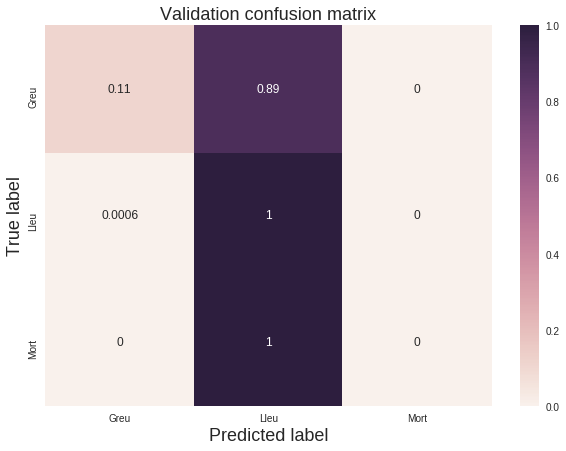

In [202]:
cm = confusion_matrix(ytest.values.argmax(axis=1), y_pred.argmax(axis=1))
# cm = confusion_matrix(ytest, y_pred.round())
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=['Greu','Lleu','Mort'], title='Validation confusion matrix')

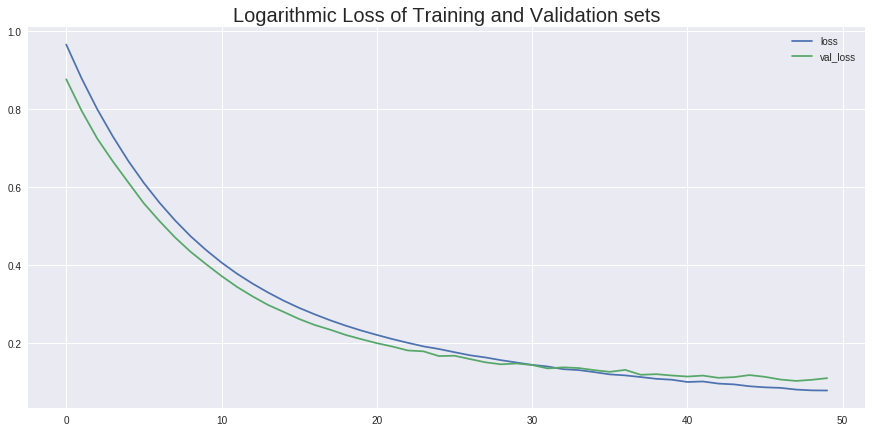

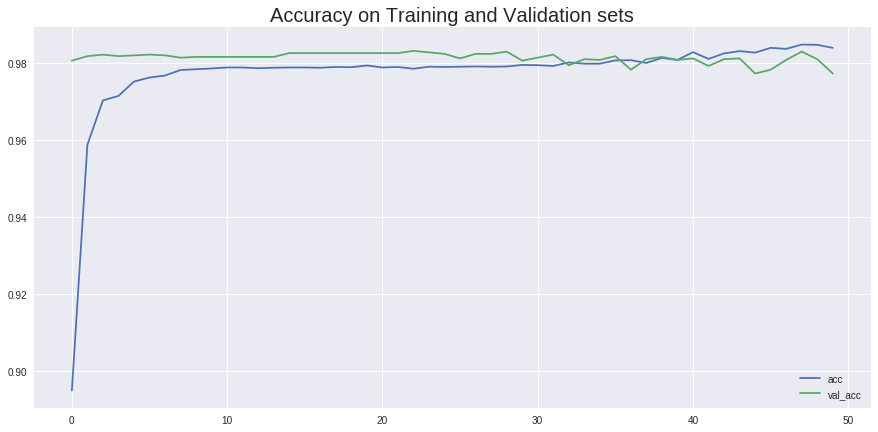

In [203]:
# plot some data
fig = plt.figure(figsize=(15,7))

plt.plot(fited_model.history['loss'], label='loss')
plt.plot(fited_model.history['val_loss'], label='val_loss')
plt.title('Logarithmic Loss of Training and Validation sets', fontsize=20)

plt.legend()
plt.show()

# accuracies
fig = plt.figure(figsize=(15,7))

plt.plot(fited_model.history['acc'], label='acc')
plt.plot(fited_model.history['val_acc'], label='val_acc')
plt.title('Accuracy on Training and Validation sets', fontsize=20)

plt.legend()
plt.show()